## Imports

In [1]:
import json
import os
import os.path as osp
import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apxinfer.core.model import XIPModel
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, recall_score
from willump.evaluation.willump_executor import willump_execute


## Task Specifics (Specific)

In [2]:

from apxinfer.examples.tdfraud.trainer import TDFraudTrainer
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('-t', '--task_name')
parser.add_argument('-s', '--seed', type=int)
args = parser.parse_args()

working_dir = os.getcwd()
experiment_path = "experiment-results" # change to your own
task_name = args.task_name if args.task_name else "tdfraudralf"
model_name = "xgb"
model_file = "xgb.pkl"
preparation_rescale = 1
if working_dir == '/home/ckchang/Biathlon/willump-adaptation':
  os.chdir('..')
assert working_dir == '/home/ckchang/Biathlon'
working_dir = os.getcwd()

## Model Training Parameters

In [3]:

# model arguments
seed = args.seed if args.seed else 0
scaler_type = None
multi_class = False


## Loading Model, Data and Feature

In [4]:

# read in the model
original_model = joblib.load(osp.join(working_dir, experiment_path, task_name, "model", model_file))

# read the dataset
train_set = pd.read_csv(osp.join(working_dir, experiment_path, task_name, "dataset", "train_set.csv"))
test_set = pd.read_csv(osp.join(working_dir, experiment_path, task_name, "dataset", "test_set.csv"))
num_rows = len(test_set)


cols = list(train_set.columns)
fnames = [col for col in cols if col.startswith("f_")]
label_name = cols[-1]

def read_feature_info():
  # read in the feature info
  qcosts = json.load(open(osp.join(working_dir, experiment_path, task_name, "qcosts.json"), "r"))
  num_reqs = qcosts["nreqs"]
  group_costs = qcosts["qcosts"]
  return (num_reqs, group_costs)

num_reqs, group_costs = read_feature_info()
num_groups = len(group_costs)
num_reqs *= preparation_rescale

## Willump Registration Functions (Specific)

In [5]:

# training
def willump_train(y, X_list):
  X = np.concatenate(X_list, axis=1)
  # X = pd.concat(X_list, axis=1)
  trainer = TDFraudTrainer(
    working_dir,
    original_model.model_type,
    model_name,
    seed,
    scaler_type,
    multi_class,
  )
  model = trainer.build_model(X, y)
  return model


def willump_predict(model, X_list):
  X = np.concatenate(X_list, axis=1)
  # X = pd.concat(X_list, axis=1)
  if X.shape[0] == 0:
    return np.zeros(0, dtype=np.int64)
  else:
    return model.predict(X)


def willump_confidence(model: XIPModel, X_list):
  X = np.concatenate(X_list, axis=1)
  # X = pd.concat(X_list, axis=1)
  return model.predict_proba(X)[:, 1]


def willump_score(true_y, pred_y):
  return roc_auc_score(true_y, pred_y)



### Generated Transformation Functions

In [6]:

def pseudo_transform_function0(input_x):
  time.sleep(group_costs[0] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q0")]].to_numpy()


def pseudo_transform_function1(input_x):
  time.sleep(group_costs[1] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q1")]].to_numpy()


def pseudo_transform_function2(input_x):
  time.sleep(group_costs[2] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q2")]].to_numpy()


def pseudo_transform_function3(input_x):
  time.sleep(group_costs[3] * input_x.shape[0] / num_reqs)
  return input_x[[fname for fname in fnames if fname.endswith("q3")]].to_numpy()



cascades_dict = {}
@willump_execute(
  train_function=willump_train,
  predict_function=willump_predict,
  confidence_function=willump_confidence,
  score_function=willump_score,
  train_cascades_params=cascades_dict,
)
def willump_train_pipeline(input_x, input_y):
  feature0 = pseudo_transform_function0(input_x)
  feature1 = pseudo_transform_function1(input_x)
  feature2 = pseudo_transform_function2(input_x)
  feature3 = pseudo_transform_function3(input_x)
  return willump_train(input_y, [feature0, feature1, feature2, feature3])



## Training with Willump

In [7]:

willump_train_pipeline(train_set[fnames], train_set[label_name].to_numpy())
willump_model = willump_train_pipeline(train_set[fnames], train_set[label_name].to_numpy())
print("Cascades dict contents:", cascades_dict)


INFO:XIPTrainer:Building pipeline for classifier xgb
INFO:XIPTrainer:Building pipeline for classifier xgb
INFO:XIPTrainer:Building pipeline for classifier xgb
INFO:XIPTrainer:Building pipeline for classifier xgb


Feature: feature0                  Cost:  0.828 Importance:  0.265
Feature: feature1                  Cost: 317.226 Importance:  0.044
Feature: feature3                  Cost: 332.860 Importance:  0.025
Feature: feature2                  Cost: 323.348 Importance:  0.009
Cutoff: 0.100000 Threshold: 0.600000 Expected Cost: 16.074101


INFO:XIPTrainer:Building pipeline for classifier xgb
INFO:XIPTrainer:Building pipeline for classifier xgb


Cutoff: 0.400000 Threshold: 0.900000 Expected Cost: 376.121309
Cascades dict contents: {'selected_feature_indices': [0], 'cascade_threshold': 0.6, 'full_model': XIPClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic', ...), 'approximate_model': XIPClassifier(base_score=None, booster=None, call

## Evaluation

In [8]:

result_dict = {"baseline": {}, "willump": {}, "preparation_rescale": preparation_rescale}

### Baseline (Specific)

In [9]:

## baseline
def willump_eval_pipeline(input_x, model):
  feature0 = pseudo_transform_function0(input_x)
  feature1 = pseudo_transform_function1(input_x)
  feature2 = pseudo_transform_function2(input_x)
  feature3 = pseudo_transform_function3(input_x)
  return willump_predict(model, [feature0, feature1, feature2, feature3])

unopt_time_elapsed_total = 0
result_dict["baseline"]["latency"] = []
baseline_preds = np.zeros(num_rows)

for i in range(num_rows):
  entry = test_set.iloc[i:i+1]
  time_start = time.time()
  preds = willump_eval_pipeline(entry, willump_model)
  time_elapsed = time.time() - time_start
  result_dict["baseline"]["latency"].append(time_elapsed)
  baseline_preds[i] = int(preds[0])
  unopt_time_elapsed_total += time_elapsed
baseline_throughput = num_rows / unopt_time_elapsed_total
baseline_accuracy = accuracy_score(test_set[label_name], baseline_preds)
baseline_precision = precision_score(test_set[label_name], baseline_preds)
baseline_recall = recall_score(test_set[label_name], baseline_preds)
baseline_f1 = f1_score(test_set[label_name], baseline_preds)
baseline_roc = roc_auc_score(test_set[label_name], baseline_preds)


print("Elapsed Time %fs" % unopt_time_elapsed_total)
print("Throughput: %f" % baseline_throughput)
print("Accuracy: %f" % baseline_accuracy)

result_dict["baseline"]["throughput"] = baseline_throughput
result_dict["baseline"]["accuracy"] = baseline_accuracy
result_dict["baseline"]["precision"] = baseline_precision
result_dict["baseline"]["recall"] = baseline_recall
result_dict["baseline"]["f1"] = baseline_f1
result_dict["baseline"]["roc"] = baseline_roc


Elapsed Time 996.647484s
Throughput: 5.124179
Accuracy: 0.940670


### Willump (Specific)

In [10]:

## Willump cascade
@willump_execute(
  predict_function=willump_predict,
  confidence_function=willump_confidence,
  predict_cascades_params=cascades_dict,
)
def willump_eval_pipeline_cascades(input_x, model):
  feature0 = pseudo_transform_function0(input_x)
  feature1 = pseudo_transform_function1(input_x)
  feature2 = pseudo_transform_function2(input_x)
  feature3 = pseudo_transform_function3(input_x)
  return willump_predict(model, [feature0, feature1, feature2, feature3])

# willump_eval_pipeline_cascades(test_set[:100], willump_model) # Warm-up?
# willump_eval_pipeline_cascades(test_set[:100], willump_model)

cascades_time_elapsed_total = 0
result_dict["willump"]["latency"] = []
result_dict["willump"]["approx_conf"] = []
approximate_model = cascades_dict["approximate_model"]
selected_feature_indices = cascades_dict["selected_feature_indices"]
willump_preds = np.zeros(num_rows)

for i in range(num_rows):
  entry = test_set.iloc[i:i+1]
  time_start = time.time()
  preds = willump_eval_pipeline_cascades(entry, willump_model)
  time_elapsed = time.time() - time_start
  result_dict["willump"]["latency"].append(time_elapsed)
  willump_preds[i] = int(preds[0])

  transform_template = 'pseudo_transform_function{}(entry)'
  feats = [eval(transform_template.format(i)) for i in selected_feature_indices]
  transformed_entry = np.hstack(feats)
  approx_conf = approximate_model.predict_proba(transformed_entry)
  result_dict["willump"]["approx_conf"].append(float(approx_conf[0, 1]))
  cascades_time_elapsed_total += time_elapsed
willump_throughput = num_rows / cascades_time_elapsed_total
willump_accuracy = accuracy_score(test_set[label_name], willump_preds)
willump_precision = precision_score(test_set[label_name], willump_preds)
willump_recall = recall_score(test_set[label_name], willump_preds)
willump_f1 = f1_score(test_set[label_name], willump_preds)
willump_roc = roc_auc_score(test_set[label_name], willump_preds)
relative_accuracy = accuracy_score(baseline_preds, willump_preds)
relative_precision = precision_score(baseline_preds, willump_preds)
relative_recall = recall_score(baseline_preds, willump_preds)
relative_f1 = f1_score(baseline_preds, willump_preds)
relative_roc = roc_auc_score(baseline_preds, willump_preds)

print("Elapsed Time %fs" % cascades_time_elapsed_total)
print("Throughput: %f" % willump_throughput)
print("Accuracy: %f" % willump_accuracy)

result_dict["willump"]["throughput"] = willump_throughput
result_dict["willump"]["accuracy"] = willump_accuracy
result_dict["willump"]["precision"] = willump_precision
result_dict["willump"]["recall"] = willump_recall
result_dict["willump"]["f1"] = willump_f1
result_dict["willump"]["roc"] = willump_roc
result_dict["willump"]["relative_accuracy"] = relative_accuracy
result_dict["willump"]["relative_precision"] = relative_precision
result_dict["willump"]["relative_recall"] = relative_recall
result_dict["willump"]["relative_f1"] = relative_f1
result_dict["willump"]["relative_roc"] = relative_roc
result_dict["willump"]["cascades"] = {}
result_dict["willump"]["cascades"]["selected_feature_indices"] = cascades_dict["selected_feature_indices"]
result_dict["willump"]["cascades"]["cascade_threshold"] = cascades_dict["cascade_threshold"]


Elapsed Time 48.385303s
Throughput: 105.548580
Accuracy: 0.943803


### Saving Result

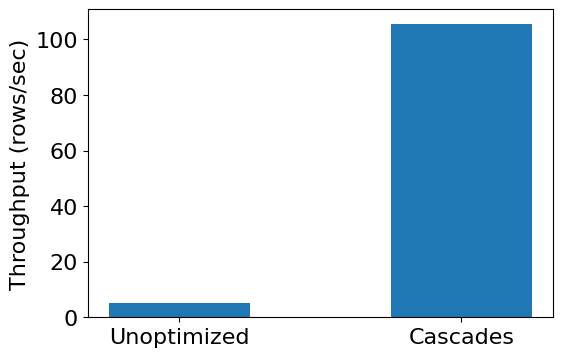

In [11]:
with open(osp.join(working_dir, "willump-adaptation", "result", f"{task_name}_{model_name}.json"), "w") as f:
  json_string = json.dumps(result_dict, indent=4)
  f.write(json_string)


plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
fig, axes = plt.subplots(figsize=(6, 4), ncols=1, nrows=1,
                         sharex=False, sharey=False)
x = np.arange(2)
width = 0.5  # the width of the bars

bars = axes.bar(x, [num_rows / unopt_time_elapsed_total, num_rows / cascades_time_elapsed_total], width)
axes.set(xlabel='', ylabel='Throughput (rows/sec)')
axes.set_xticks(x)
axes.set_xticklabels(["Unoptimized", "Cascades"])
plt.savefig(osp.join(working_dir, "willump-adaptation", "result", f"{task_name}_{model_name}.jpg"))
